# Monte Carlo in spinfoams

Description of the notebook

## Setup

In [1]:
using CSV
using DataFrames

In [2]:
using Statistics
using StatsBase
using StatsPlots

## Loading Data

Load the data of all the layers

In [3]:
DIRECTORY = "/home/pdona/Desktop/ExportData/data/self_energy/jb_0.5/exact/BF/internal_contributions"
LAYER = Dict()

for k in 0.5:0.5:10.0
    LAYER[k] = DataFrame(
            CSV.File(
                "$(DIRECTORY)/internal_pcutoff_$(k).csv",
                header=false
            ),
        ).Column7
end

Fake MonteCarlo function

In [4]:
function MCSum(vector, Nmc)
    vol = length(vector)
    randomsample = sample(vector,Nmc,replace=true)
    return sum(randomsample)*vol/Nmc
end

MCSum (generic function with 1 method)

In [5]:
exact_layers = [sum(LAYER[k]) for k in 0.5:0.5:10.0];

In [6]:
function relative_error(vector)
    s = std(vector);
    m = mean(vector);
    return 100*s/m
end

relative_error (generic function with 1 method)

# Trials analysis for each layer

We start looking at $10$, $20$, $50$ trials. How can we evaluate what is a good estimate of the error? We look at the boxplot of averages of multiple realizations of $T$ trials

In [7]:
function sample_samples(k,T)
    return [(mean([MCSum(LAYER[k],1000) for _ in 1:T])/exact_layers[Integer(2*k)]-1) for _ in 1:100]
end

sample_samples (generic function with 1 method)

In [8]:
test_10trials = DataFrame();
test_20trials = DataFrame();
test_50trials = DataFrame();

In [11]:
test_10trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_10trials[!,"MCestimate"] = vcat([sample_samples(k,10) for k in 5.0:0.5:10.0]...);

test_20trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_20trials[!,"MCestimate"] = vcat([sample_samples(k,20) for k in 5.0:0.5:10.0]...);

test_50trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_50trials[!,"MCestimate"] = vcat([sample_samples(k,50) for k in 5.0:0.5:10.0]...);

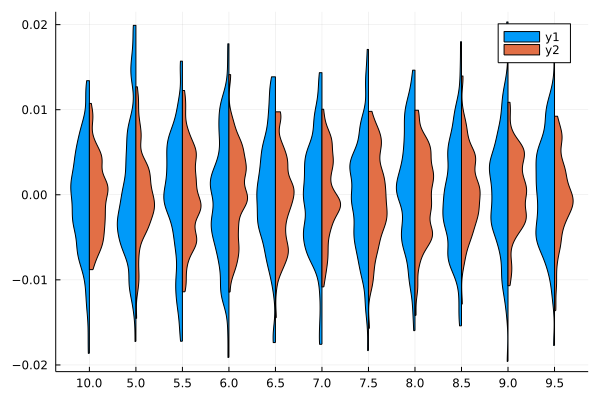

In [22]:
@df test_10trials violin(string.(:Layer),:MCestimate, side = :left)
@df test_20trials violin!(string.(:Layer),:MCestimate,side = :right)

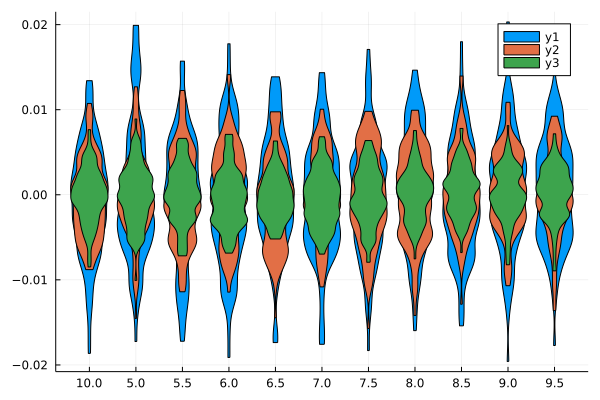

In [23]:
@df test_10trials violin(string.(:Layer),:MCestimate)
@df test_20trials violin!(string.(:Layer),:MCestimate)
@df test_50trials violin!(string.(:Layer),:MCestimate)

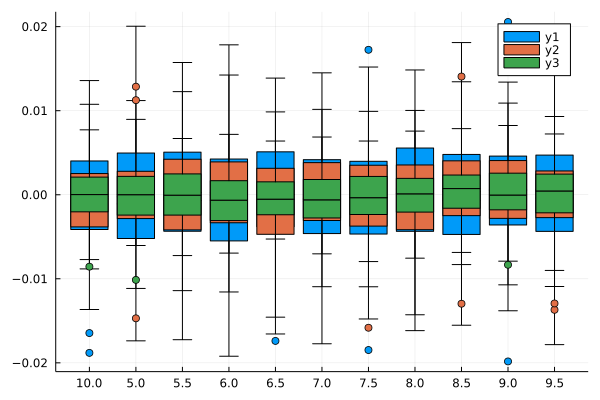

In [24]:
@df test_10trials boxplot(string.(:Layer),:MCestimate)
@df test_20trials boxplot!(string.(:Layer),:MCestimate)
@df test_50trials boxplot!(string.(:Layer),:MCestimate)

In [27]:
total_df = vcat(test_10trials,test_20trials,test_50trials,source="source");

In [ ]:
@df total_df groupedboxplot(string.(:Layer),:MCestimate,group = :source, bar_position = :dodge,size=(800,200))

In [69]:
teststd10 = [relative_error([MCSum(LAYER[10.0],1000) for _ in 1:10]) for _ in 1:100];
teststd20 = [relative_error([MCSum(LAYER[10.0],1000) for _ in 1:20]) for _ in 1:100];
teststd50 = [relative_error([MCSum(LAYER[10.0],1000) for _ in 1:50]) for _ in 1:100];

In [71]:
println("10 trials: median = $(median(teststd10)), quantile.25 = $(quantile(teststd10,1/4)), quantile.75 = $(quantile(teststd10,3/4))")
println("20 trials: median = $(median(teststd20)), quantile.25 = $(quantile(teststd20,1/4)), quantile.75 = $(quantile(teststd20,3/4))")
println("50 trials: median = $(median(teststd50)), quantile.25 = $(quantile(teststd50,1/4)), quantile.75 = $(quantile(teststd50,3/4))")

10 trials: median = 2.0642541939395698, quantile.25 = 1.7599625358881523, quantile.75 = 2.410188351842732
20 trials: median = 2.1872356108540147, quantile.25 = 1.9769876771703685, quantile.75 = 2.531262366743352
50 trials: median = 2.163406867885133, quantile.25 = 2.029048676834469, quantile.75 = 2.3314599071684707


It looks to me that we need at least 20 trials if not more. With $N_{mc}=1000$ and $10$ trials we can estimate the percentage error between $1.76$ and $2.41$. With $20$ trials between $1.98$ and $2.53$ with shorter tails. With $50$ trials between $2.03$ and $2.33$ with even shorter tails. 
Is it true also for larger number of Nmc?

In [72]:
teststd10 = [relative_error([MCSum(LAYER[10.0],10000) for _ in 1:10]) for _ in 1:100];
teststd20 = [relative_error([MCSum(LAYER[10.0],10000) for _ in 1:20]) for _ in 1:100];
teststd50 = [relative_error([MCSum(LAYER[10.0],10000) for _ in 1:50]) for _ in 1:100];

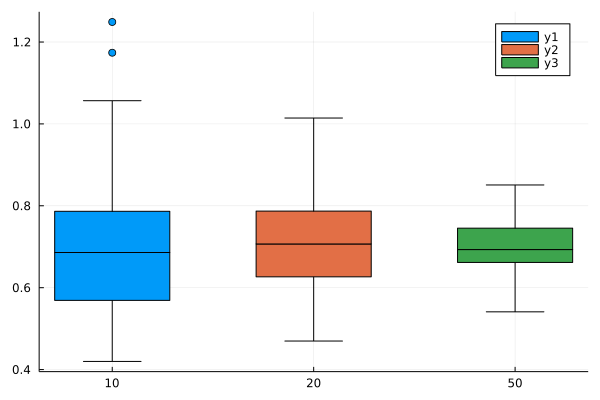

In [73]:
boxplot(["10"],teststd10)
boxplot!(["20"],teststd20)
boxplot!(["50"],teststd50)

In [74]:
println("10 trials: median = $(median(teststd10)), quantile.25 = $(quantile(teststd10,1/4)), quantile.75 = $(quantile(teststd10,3/4))")
println("20 trials: median = $(median(teststd20)), quantile.25 = $(quantile(teststd20,1/4)), quantile.75 = $(quantile(teststd20,3/4))")
println("50 trials: median = $(median(teststd50)), quantile.25 = $(quantile(teststd50,1/4)), quantile.75 = $(quantile(teststd50,3/4))")

10 trials: median = 0.6858515518885815, quantile.25 = 0.5689861738400152, quantile.75 = 0.7864813539223826
20 trials: median = 0.7068150046760466, quantile.25 = 0.6265780892460948, quantile.75 = 0.7870940679456807
50 trials: median = 0.6930325412631828, quantile.25 = 0.6616580127989047, quantile.75 = 0.7454220154266626


In [75]:
teststd10 = [relative_error([MCSum(LAYER[10.0],100000) for _ in 1:10]) for _ in 1:100];
teststd20 = [relative_error([MCSum(LAYER[10.0],100000) for _ in 1:20]) for _ in 1:100];
teststd50 = [relative_error([MCSum(LAYER[10.0],100000) for _ in 1:50]) for _ in 1:100];

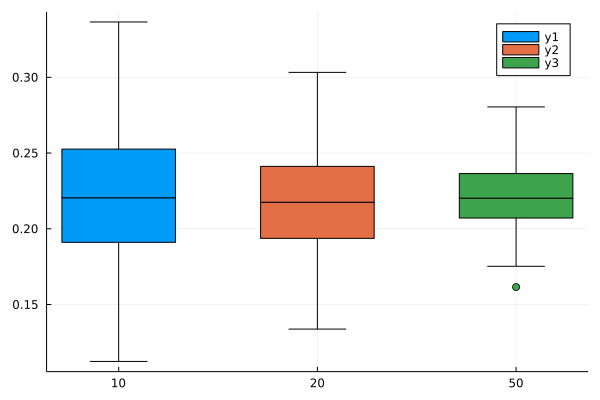

In [76]:
boxplot(["10"],teststd10)
boxplot!(["20"],teststd20)
boxplot!(["50"],teststd50)

In [77]:
println("10 trials: median = $(median(teststd10)), quantile.25 = $(quantile(teststd10,1/4)), quantile.75 = $(quantile(teststd10,3/4))")
println("20 trials: median = $(median(teststd20)), quantile.25 = $(quantile(teststd20,1/4)), quantile.75 = $(quantile(teststd20,3/4))")
println("50 trials: median = $(median(teststd50)), quantile.25 = $(quantile(teststd50,1/4)), quantile.75 = $(quantile(teststd50,3/4))")

10 trials: median = 0.22046703251934813, quantile.25 = 0.1910513134847535, quantile.75 = 0.2525795200001025
20 trials: median = 0.2174990288049917, quantile.25 = 0.19366201053939813, quantile.75 = 0.24119665158031145
50 trials: median = 0.22020402717773832, quantile.25 = 0.20709364957047427, quantile.75 = 0.23644692128806125


The situation is the same. It is interesting to note the relations between the error %. With $N_{mc}=1000$ we have an error of approx 2.2%, with $N_{mc}=10000$ we have an error of approx 0.7% and with $N_{mc}=100000$ we have an error of approx 0.22%. The ratio between errors is more or less compatible with the sqrt of the ratios of the $N_{mc}$ given $\sqrt{10}\approx 3.16$. 

We expect it since the error is a good estimate of the MC variance that scale with $\sqrt{N_{mc}}$